# ChatGLM初探

In [1]:
from transformers import AutoTokenizer, AutoModel

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
tokenizer = AutoTokenizer.from_pretrained("/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base", trust_remote_code=True)
tokenizer

ChatGLMTokenizer(name_or_path='/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base', vocab_size=64798, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='left', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	
}

In [3]:
import torch
model = AutoModel.from_pretrained("/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base", 
                                  trust_remote_code=True, 
                                  low_cpu_mem_usage=True, 
                                  torch_dtype=torch.half, 
                                  device_map="auto")

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

## chatglm chat方法

In [5]:
model.chat(tokenizer, "python代码使用if-else", history=[])
# 返回两个tuple：第一个是返回的消息，第二个是历史记录

({'name': '1. 首先，我们需要明确if-else结构的基本语法： ``` if 条件语句: 语句1 elif 条件语句: 语句2 else: 语句3 ``` 2. 然后，我们需要了解if-else结构中各个部分的作用： - `if`：表示条件判断，如果条件成立，则执行`if`后面的语句； - `elif`：表示多个条件判断，如果第一个条件成立，则执行`if`后面的语句；如果第一个条件不成立，但第二个条件成立，则执行`elif`后面的语句；以此类推，直到所有的条件都不成立为止； - `else`：表示如果所有的条件都不成立，则执行`else`后面的语句。 3. 最后，我们需要知道if-else结构的使用方法： - 首先，我们需要明确一个条件，可以使用`if`语句来判断； - 如果条件成立，则执行`if`后面的语句； - 如果条件不成立，但还有其他条件，则使用`elif`语句来判断； - 如果所有的条件都不成立，则执行`else`后面的语句。 4. 下面，我们来看一个具体的例子： ``` python code def check_age(age): if age >= 18: print("You are an adult.") elif age < 18: print("You are a child.") else: print("You are not a child nor an adult.") check_age(12) check_age(20) check_age(0) ``` 5. 在上述代码中，我们定义了一个函数`check_age`，该函数接受一个参数`age`，用来判断该人的年龄。如果年龄大于等于18，则输出"You are an adult."，否则输出"You are a child."，如果年龄既不是儿童也不是成人，则输出"You are not a child nor an adult."。 6. 最后，我们调用该函数，并分别传入不同的参数，测试该函数的运行结果。',
  'content': ''},
 [{'role': 'user', 'content': 'python代码使用if-else'},
  {'role': 'assistant',
   'metadata': '1. 首先，我们需要明确if-else结

In [6]:
# 方法介绍
?model.chat

Signature:
model.chat(
    tokenizer,
    query: str,
    history: List[Tuple[str, str]] = None,
    role: str = 'user',
    max_length: int = 8192,
    num_beams=1,
    do_sample=True,
    top_p=0.8,
    temperature=0.8,
    logits_processor=None,
    **kwargs,
)
Docstring: <no docstring>
File:      /data1/zhengnanyan/huggingface/modules/transformers_modules/chatglm3-6b-base/modeling_chatglm.py
Type:      method

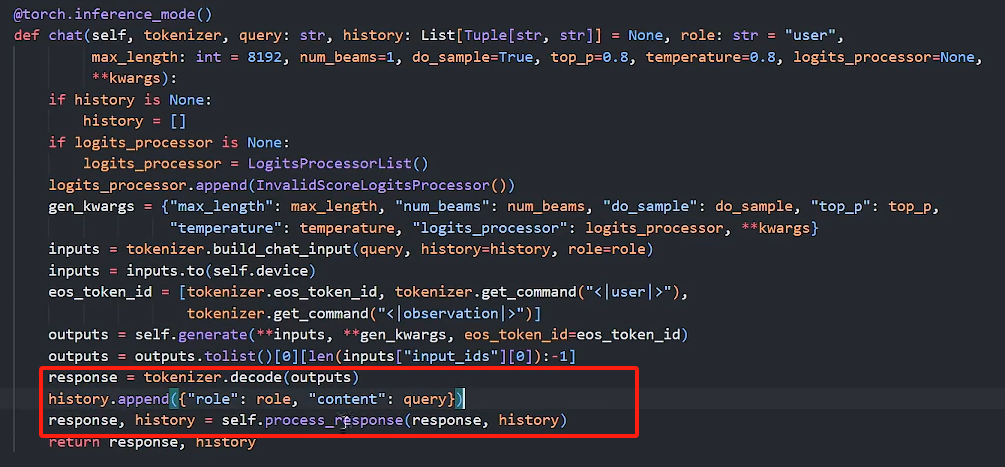

In [7]:
?tokenizer.build_chat_input

Signature: tokenizer.build_chat_input(query, history=None, role='user')
Docstring: <no docstring>
File:      /data1/zhengnanyan/huggingface/modules/transformers_modules/chatglm3-6b-base/tokenization_chatglm.py
Type:      method

## tokenizer.get_command

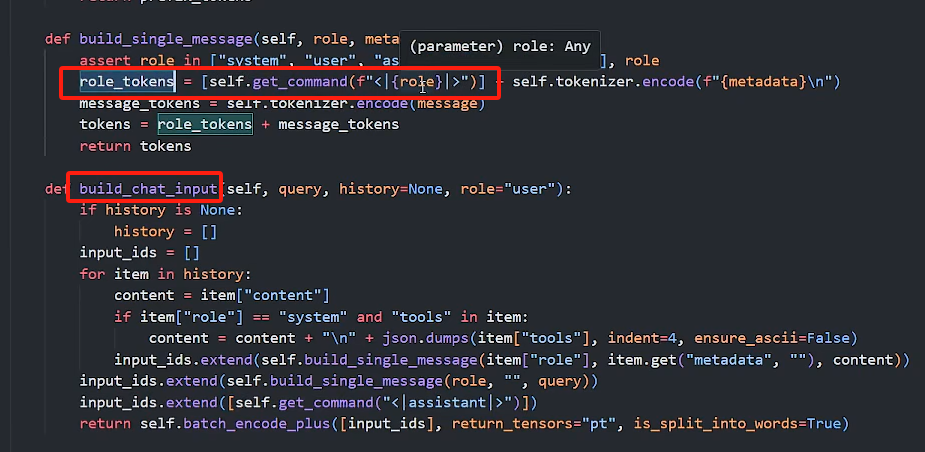

只有通过get_command才能获得真正special token的token id。

special token：\<user> 、 \<role>

所以，要获得token_id:

- special token: tokenizer.get_command(f"<|{role}|>")

- 普通文本： tokenizer.encode(message)

In [8]:
tokenizer("<|user|>", add_special_tokens=False)

{'input_ids': [906, 31007, 4865, 31007, 30994], 'attention_mask': [1, 1, 1, 1, 1], 'position_ids': [0, 1, 2, 3, 4]}

In [9]:
tokenizer.get_command("<|user|>")

64795

In [10]:
tokenizer.build_chat_input("考试的技巧有哪些？", history=[], role="user")

{'input_ids': tensor([[64790, 64792, 64795, 30910,    13, 30910, 32227, 54530, 33741, 34953,
         31514, 64796]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'position_ids': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])}

In [11]:
tokenizer.decode([64790, 64792, 64795, 30910,    13, 30910, 32227, 54530, 33741, 34953,
         31514, 64796])

'[gMASK]sop<|user|> \n 考试的技巧有哪些？<|assistant|>'

数据格式：

[gMASK]sop<|user|> \n Prompt<|assistant|> \n Response eos_token

上面就是进到模型前，要把数据处理好的样子

**训练数据，response前一定要加上\n，因为会根据\n做split**

模型回复的，就是assistant的输出